# Part 1. Basic: Solving Uber Pool Problem with Q-learning

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/MyDrive/INM707_DRL_CW/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import random
from random import randint, randint, choice
import itertools

from IPython.display import clear_output
from time import sleep

%matplotlib inline
import ql_plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27


# 2. CityGrid Environment 

In [ ]:
class CityGrid(): 
  
  def __init__(self, height, width):
    self.height = height
    self.width = width
    self.size = width * height
    self.CityGrid = np.zeros((height, width))

    self.passenger_loc1 = None
    self.passenger_loc2 = None
    self.destination_loc1 = None
    self.destination_loc2 = None
    self.car_location = None
    self.current_position = None
    self.current_state = None

    self.terminal_state = False
    self.passenger1_picked = False
    self.passenger1_dropped = False
    self.passenger2_picked = False
    self.passenger2_dropped = False

    self.reward = 0
    self.next_position = None 
    self.time_elapsed = 0
    self.time_limit = self.size*2

    ## ====================================================================== ##
    ## ---------------------------- DICTIONARIES ---------------------------- ##
    ## ====================================================================== ##
    self.grid_display = { 0: ".", # unassigned
                          1: "\033[1;90m■\033[0m", # wall
                          2: ".", # empty cells
                          3: "\033[1;32;41mP\033[0m", # passenger
                          4: "\033[1;31;42mD\033[0m", # destination
                          5: "\033[1;34;43mC\033[0m" # car
                        }
    self.cell_assigner = { "wall": 1,
                           "cell": 2,
                           "passenger": 3,
                           "destination": 4,
                           "car": 5
                          }
    self.action_dict = {"north": (-1,0),
                        "south": (1,0),
                        "west": (0,-1),
                        "east": (0,1),
                        "pick_up": (0,0),
                        "drop_off": (0,0)
                        }
    self.action_indexer = {
        "north": 0,
        "south": 1,
        "west": 2,
        "east": 3,
        "pick_up": 4,
        "drop_off": 5
    }

    # Run function to build the city grid using randomized prim algorithm 
    # -> refer to the _city_builder function below
    self._city_builder()

    ## ====================================================================== ##
    ## -------------------- ASSIGNING PASSENGER LOCATIONS ------------------- ##
    ## ⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄ ##

    P = self._get_empty_cells(2) # pick 2 random coordinates for passenger locations
    # -- PASSENGER 1 -- position coodinates
    self.passenger_loc1 = P[0]
    self.passenger1_initial = self.passenger_loc1 # assign initial passenger 1 location before successful pick_up
    self.CityGrid[self.passenger_loc1[0], self.passenger_loc1[1]] = self.cell_assigner["passenger"] # assign 3=>P as passenger cell for display
    # -- PASSENGER 2 -- position coodinates
    self.passenger_loc2 = P[1]
    self.passenger2_initial = self.passenger_loc2 # assign initial passenger 2 location before successful pick_up
    self.CityGrid[self.passenger_loc2[0], self.passenger_loc2[1]] = self.cell_assigner["passenger"] # assign 3=>P as passenger cell for display
    
    ## ====================================================================== ##
    ## -------------------- ASSIGNING DESTINATION LOCATIONS ----------------- ##
    ## ⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄ ##
  
    D = self._get_empty_cells(2)  # pick 2 random coordinates for destination locations
    # -- DESTINATION 1 -- position coodinates
    self.destination_loc1 = D[0]
    self.destination1_initial = self.destination_loc1 # assign initial destination 1 location before successful drop_off
    self.CityGrid[self.destination_loc1[0], self.destination_loc1[1]] = self.cell_assigner["destination"] # assign 2=>D as destination cell for display
    # -- DESTINATION 2 -- position coodinates
    self.destination_loc2 = D[1]
    self.destination2_initial = self.destination_loc2 # assign initial destination 1 location before successful drop_off
    self.CityGrid[self.destination_loc2[0], self.destination_loc2[1]] = self.cell_assigner["destination"] # assign 2=>D as destination cell for display

    ## ====================================================================== ##
    ## ---------------------- ASSIGNING CAR LOCATIONS ----------------------- ##
    ## ⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄ ##

    self.car_location = self._get_empty_cells(1)[0] # pick 1 random coordinate for car location
    self.initial_car_loc = self.car_location # assign initial car location before any action steps

    ## ====================================================================== ##
    ## ------------------- DEFINING STATE & ACTION SPACE -------------------- ##
    ## ⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄ ##
    
    self.action_space = len(self.action_dict.keys()) # 6 actions ('north', 'south', 'west', 'east', 'pick_up', drop_off')
    self.state_space = self.size * 7 
    ## 7 individual subspaces  ##
        # (1) no successful pick up or drop off yet, 
        # (2) P1 picked up only, no drop offs, 
        # (3) P2 picked up only no drop offs
        # (4) P1 and P2 both picked up, no drop offs yet
        # (5) P1 and P2 both picked, and P1 dropped off only
        # (6) P1 and P2 both picked, and P2 dropped off only
        # (7) TERMINAL STATE -> P1 and P2 both picked, and P1 and P2 both dropped off

    state_idx = np.arange(0, self.state_space)
    self.state_idx_coord = state_idx.reshape(7, self.height, self.width) # defining (7, height, width) state matrix
    

    # < ================================================================================================================================================ >
    # < ------------------------------------------------- STATE TRANSITION & REWARD FUNCTIONS ---------------------------------------------------------- > 
    # < ⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄ >

    # Definition of transition and reward matrices
    # Fill in both matrices with appropriate values
    self.reward_matrix = np.zeros((self.state_space, 6))
    self.reward_matrix[:] = np.nan
    self.transition_matrix = np.zeros((self.state_space, 6, self.state_space))
    
    for h in range(6):  
        for i in range(1, self.height-1):
            for j in range(1, self.width - 1):
                current_state = self.state_idx_coord[h,i,j]
                current_cell = self.CityGrid[i,j]
                
                for action in self.action_dict.keys():
                    
                    destination_cell = self.CityGrid[i + self.action_dict[action][0], j + self.action_dict[action][1]]
                    next_state = self.state_idx_coord[h, i + self.action_dict[action][0], j + self.action_dict[action][1]]
    

                    if current_cell == 1:
                        continue

                    if destination_cell in [0,2,3,4]:
                        
                        self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                        self.reward_matrix[current_state, self.action_indexer[action]] = -1
                        
                    elif destination_cell == 1:
                        destination_cell = current_cell
                        next_state = current_state
                        self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                        self.reward_matrix[current_state, self.action_indexer[action]] = -5

                    if destination_cell == 3 and action == "pick_up":
                        if h == 0:
                            self.reward_matrix[current_state, self.action_indexer[action]] = 100
                            # Check for passenger 1
                            if i == self.passenger_loc1[0] and j == self.passenger_loc1[1]:
                                next_state = self.state_idx_coord[h+1, i, j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                            # Check for passenger 2 
                            elif i == self.passenger_loc2[0] and j == self.passenger_loc2[1]:
                                next_state = self.state_idx_coord[h+2, i, j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                        elif h == 1:
                            # Check for passenger 1
                            if i == self.passenger_loc1[0] and j == self.passenger_loc1[1]:
                                self.reward_matrix[current_state, self.action_indexer[action]] = -10
                                next_state = self.state_idx_coord[h, i, j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                            # Check for passenger 2 
                            elif i == self.passenger_loc2[0] and j == self.passenger_loc2[1]:
                                self.reward_matrix[current_state, self.action_indexer[action]] = 100
                                next_state = self.state_idx_coord[h+2, i, j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                        elif h == 2:
                            # Check for passenger 1
                            if i == self.passenger_loc1[0] and j == self.passenger_loc1[1]:
                                self.reward_matrix[current_state, self.action_indexer[action]] = 100
                                next_state = self.state_idx_coord[h+1, i, j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                            # Check for passenger 2 
                            elif i == self.passenger_loc2[0] and j == self.passenger_loc2[1]:
                                self.reward_matrix[current_state, self.action_indexer[action]] = -10
                                next_state = self.state_idx_coord[h, i, j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1         
                        else:
                            self.reward_matrix[current_state, self.action_indexer[action]] = -10
                            next_state = self.state_idx_coord[h, i, j]
                            self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                            
                                          
                    elif destination_cell != 3 and action == "pick_up":
                        self.reward_matrix[current_state, self.action_indexer[action]] = -10

                    if destination_cell == 4 and action == "drop_off":
                        if h == 3:
                            self.reward_matrix[current_state, self.action_indexer[action]] = 100
                            # Check for passenger 1
                            if i == self.destination_loc1[0] and j == self.destination_loc1[1]:
                                next_state = self.state_idx_coord[h+1,i,j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                            # Check for passenger 2
                            elif i == self.destination_loc2[0] and j == self.destination_loc2[1]:
                                next_state = self.state_idx_coord[h+2,i,j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                        elif h == 4:
                            # Check for passenger 1
                            if i == self.destination_loc1[0] and j == self.destination_loc1[1]:
                                self.reward_matrix[current_state, self.action_indexer[action]] = -10
                                next_state = self.state_idx_coord[h,i,j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                            # Check for passenger two 
                            elif i == self.destination_loc2[0] and j == self.destination_loc2[1]:
                                self.reward_matrix[current_state, self.action_indexer[action]] = 100
                                next_state = self.state_idx_coord[h+2, i,j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1    
                        elif h == 5:
                            # Check for passenger 1
                            if i == self.destination_loc1[0] and j == self.destination_loc1[1]:
                                self.reward_matrix[current_state, self.action_indexer[action]] = 100
                                next_state = self.state_idx_coord[h+1,i,j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                            # Check for passenger two 
                            elif i == self.destination_loc2[0] and j == self.destination_loc2[1]:
                                self.reward_matrix[current_state, self.action_indexer[action]] = -10
                                next_state = self.state_idx_coord[h, i,j]
                                self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1 
                        else:
                            self.reward_matrix[current_state, self.action_indexer[action]] = -10
                            next_state = self.state_idx_coord[h,i,j]
                            self.transition_matrix[current_state, self.action_indexer[action], next_state] = 1
                            
                    elif destination_cell != 4 and action == "drop_off":
                        self.reward_matrix[current_state, self.action_indexer[action]] = -10

  # < ================================================================================================================================================ >
  # < ----------------------------------------------------- START OF CITY GRID BUILDING FUCTION ------------------------------------------------------ > 
  # < ⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄ >

  def _city_builder(self):
    random.seed(1234)  # seed the environment 

    """
        Randomized Prim's algorithm (https://en.wikipedia.org/wiki/CityGrid_generation_algorithm#Randomized_Prim's_algorithm)
        This algorithm is a randomized version of Prim's algorithm.

        1. Start with a grid full of walls.
        2. Pick a cell, mark it as part of the CityGrid. Add the walls of the cell to the wall list.
        3. While there are walls in the list:
            1. Pick a random wall from the list. If only one of the cells that the wall divides is visited, then:
                1. Make the wall a passage and mark the unvisited cell as part of the CityGrid.
                2. Add the neighboring walls of the cell to the wall list.
            2. Remove the wall from the list.
    """
        
    """
        Code adapted and modified from orifinal file in https://medium.com/swlh/fun-with-python-1-maze-generator-931639b4fb7e
    """
  
    # -- STEP 1 -- Pick random cell to start with that excludes the boundaries

    free_spot = (
        randint(1, self.height - 2), 
        randint(1, self.width - 2)
        )
    
    # -- STEP 2 -- Set the picked cell from step 1 as an empty cell
    self.CityGrid[free_spot[0], free_spot[1]] = self.cell_assigner["cell"]

    # -- STEP 3 -- Get coordinates of surrounding cells (above, below, left and right of the starting point)
    boundary = self._get_surrounding_cells(free_spot)
    
    # -- STEP 4 -- Generate walls to surround starting cell in the CityGrid.
    self.walls = []
    for wall in boundary:
        self.walls.append(wall)
        self.CityGrid[wall[0], wall[1]] = 1

    # -- STEP 5 -- Find path to build the maze - Denote new path by iterating each wall (left, right up and below of starting cell)
    while(self.walls):

      # Pick random surrounding cell from list of surrounding cells (one of four cells) 
      rc = choice(self.walls)

      # Check if it is a left wall
      if (rc[1] != 0):
        if (self.CityGrid[rc[0], rc[1]-1] == 0 and self.CityGrid[rc[0], rc[1]+1] == 2):
          # Find the number of surrounding cells
          s_cells = self._num_surrounding_cells(rc)
          if (s_cells < 2): # to make sure we don't create boxes with no exit
            # Denote the new path
            self.CityGrid[rc[0], rc[1]] = self.cell_assigner["cell"]
            # Mark the new self.walls
            if (rc[0] != 0):
                self._wall_marker(rc, "north")
            if (rc[0] != self.height-1):
                self._wall_marker(rc, "south")
            if (rc[1] != 0):	
                self._wall_marker(rc, "west")
          
          # Delete wall
          self._wall_remover(rc)
          continue

      # Check if it is an upper wall
      if (rc[0] != 0):
        if (self.CityGrid[rc[0]-1, rc[1]] == 0 and self.CityGrid[rc[0]+1, rc[1]] == 2):
          s_cells = self._num_surrounding_cells(rc)
          if (s_cells < 2):
            # Denote the new path
            self.CityGrid[rc[0], rc[1]] = self.cell_assigner["cell"]
            # Mark the new self.walls
            if (rc[0] != 0):
              self._wall_marker(rc, "north")
            if (rc[1] != 0):
              self._wall_marker(rc, "west")
            if (rc[1] != self.width-1):
              self._wall_marker(rc, "east")
            # Delete wall
          self._wall_remover(rc)
          continue

      # Check the bottom wall
      if (rc[0] != self.height-1):
        if (self.CityGrid[rc[0]+1, rc[1]] == 0 and self.CityGrid[rc[0]-1, rc[1]] == 2):
          s_cells = self._num_surrounding_cells(rc)
          if (s_cells < 2):
            # Denote the new path
            self.CityGrid[rc[0], rc[1]] = self.cell_assigner["cell"]
            # Mark the new self.walls
            if (rc[0] != self.height-1):
              self._wall_marker(rc, "south")
            if (rc[1] != 0):
              self._wall_marker(rc, "west")
            if (rc[1] != self.width-1):
              self._wall_marker(rc, "east")
          
          # Delete wall
          self._wall_remover(rc)
          continue

      # Check the right wall
      if (rc[1] != self.width-1):
        if (self.CityGrid[rc[0], rc[1]+1] == 0 and self.CityGrid[rc[0], rc[1]-1] == 2):
          s_cells = self._num_surrounding_cells(rc)
          if (s_cells < 2):
            # Denote the new path
            self.CityGrid[rc[0], rc[1]] = self.cell_assigner["cell"]
            # Mark the new self.walls
            if (rc[1] != self.width-1):
              self._wall_marker(rc, "east")
            if (rc[0] != self.height-1):
              self._wall_marker(rc, "south")
            if (rc[0] != 0):
              self._wall_marker(rc, "north")
          # Delete wall
          self._wall_remover(rc)
          continue

      # Delete the wall from the list anyway
      self._wall_remover(rc)

    # -- STEP 6 -- Mark the remaining unvisited cells as self.walls
    for i in range(0, self.height):
      for j in range(0, self.width):
        if (self.CityGrid[i, j] == 0):
          self.CityGrid[i,j] = self.cell_assigner["wall"]

  ## ======================================================================== ##
  ## ------------ Private utility functions for maze generator -------------- ##
  ## ⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄ ##

  # 1. Function for counting surrounding empty cells 
  def _num_surrounding_cells(self, cell_idx):
    s_cells = 0
    border = self._get_surrounding_cells(cell_idx)
    for cell in border:
      if self.CityGrid[cell[0], cell[1]] == 2:
        s_cells += 1
    return s_cells  
  
  # 2. Function for finding coordinates of surrounding empty cells 
  def _get_surrounding_cells(self, cell_idx):
    surrounding_cells = []
    surrounding_cells.append((cell_idx[0], cell_idx[1] - 1))
    surrounding_cells.append((cell_idx[0], cell_idx[1] + 1))
    surrounding_cells.append((cell_idx[0] - 1, cell_idx[1]))
    surrounding_cells.append((cell_idx[0] + 1, cell_idx[1]))
    return surrounding_cells

  # 3. Wall marker function
  def _wall_marker(self, cell, direction):
    coords = (cell[0] + self.action_dict[direction][0], cell[1] + self.action_dict[direction][1])
    if (self.CityGrid[coords[0], coords[1]] != 2):
      self.CityGrid[coords[0], coords[1]] = self.cell_assigner["wall"]
    if (coords[0], coords[1]) not in self.walls:
      self.walls.append((coords[0], coords[1]))
  
  # 4. Wall remover function
  def _wall_remover(self, cell):
    for wall in self.walls:
      if (wall[0] == cell[0] and wall[1] == cell[1]):
              self.walls.remove(wall)

  # < ⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃⌃ >    
  # < ----------------------------------------------------- END OF CITY GRID BUILDING FUCTION ------------------------------------------------------ >    
  # < ============================================================================================================================================== >
  
  # Empty cell coordinate generator
  def _get_empty_cells(self, n):
        empty_cells_coord = [(i, j) for i in range(self.width) for j in range(self.height) if self.CityGrid[i, j] == 2]
        selected_coords = list()
        for i in range(n):
            new_coord = random.choice(empty_cells_coord)
            selected_coords.append(new_coord)
            empty_cells_coord.remove(new_coord)
        return selected_coords


  ## ======================================================================== ##
  ## -------------------------- RESET FUNCTION ------------------------------ ##
  ## ⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄ ##

  def reset(self):
    self.car_location = self.initial_car_loc
    self.passenger_loc1 = self.passenger1_initial
    self.passenger_loc2 = self.passenger2_initial
    self.destination_loc1 = self.destination1_initial 
    self.destination_loc2 = self.destination2_initial

    # Reset passenger locations
    self.CityGrid[self.passenger_loc1[0], self.passenger_loc1[1]] = self.cell_assigner["passenger"]
    self.CityGrid[self.passenger_loc2[0], self.passenger_loc2[1]] = self.cell_assigner["passenger"]
    self.passenger1_picked = False
    self.passenger2_picked = False
    
    self.reward = 0 # reset reward to zero

    # Reset destination locations 
    self.CityGrid[self.destination_loc1[0], self.destination_loc1[1]] = self.cell_assigner["destination"]
    self.CityGrid[self.destination_loc2[0], self.destination_loc2[1]] = self.cell_assigner["destination"]
    # Reset passenger dropped variables
    self.passenger1_dropped = False
    self.passenger2_dropped = False

    # Reset time
    self.time_elapsed = 0

    # Reset terminal state
    self.terminal_state = False
    
    # Resetting back to first subspace --> (1) no successful pick up or drop off yet
    state = self.state_idx_coord[0][self.initial_car_loc[0], self.initial_car_loc[1]]
    
    return state


  ## ======================================================================== ##
  ## --------------------------- STEP FUNCTION ------------------------------ ##
  ## ⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄ ##
  
  def step(self, action):

    self.reward -= 1
    wall = False

    self.current_state = self.CityGrid[self.car_location[0], self.car_location[1]]
    self.next_position = (self.car_location[0] + self.action_dict[action][0], self.car_location[1] + self.action_dict[action][1])

    if self.CityGrid[self.next_position[0], self.next_position[1]] == self.cell_assigner["wall"]:
      wall = True
    else:
      self.car_location = self.next_position

    if wall:
      self.reward -= 5

    if action == "pick_up":
      if self.car_location == self.passenger_loc1 and self.passenger1_picked == False and self.passenger1_dropped == False:
        self.reward += self.size/2
        self.passenger1_picked = True
        self.CityGrid[self.passenger_loc1[0], self.passenger_loc1[1]] = self.cell_assigner["cell"]
        #print("Passenger 1 picked up! Enjoy your trip!")
      elif self.car_location == self.passenger_loc2 and self.passenger2_picked == False and self.passenger2_dropped == False:
        self.reward += self.size/2
        self.passenger2_picked = True
        self.CityGrid[self.passenger_loc2[0], self.passenger_loc2[1]] = self.cell_assigner["cell"]
        #print("Passenger 2 picked up! Enjoy your trip!")
      else:
        self.reward -= 10


    elif action == "drop_off":
      if self.car_location == self.destination_loc1 and self.passenger1_picked == True and self.passenger1_dropped == False and self.passenger2_picked == True:
        self.passenger1_dropped = True
        self.CityGrid[self.destination_loc1[0], self.destination_loc1[1]] = self.cell_assigner["cell"]
        self.reward += self.size
        #print("Passenger 1 dropped! Hope you enjoyed your trip!")
      elif self.car_location == self.destination_loc2 and self.passenger2_picked == True and self.passenger2_dropped == False and self.passenger1_picked == True:
        self.passenger2_dropped = True
        self.CityGrid[self.destination_loc2[0], self.destination_loc2[1]] = self.cell_assigner["cell"]
        self.reward += self.size
        #print("Passenger 2 dropped! Hope you enjoyed your trip!")
      else:
        self.reward -= 10

    if self.passenger1_dropped and self.passenger2_dropped:
      self.terminal_state = True
      #print("Both passengers have been successfully dropped!")

    self.time_elapsed += 1

    if self.time_elapsed == self.time_limit:
      self.terminal_state = True

    
    if self.passenger1_picked == False and self.passenger2_picked == False and self.passenger1_dropped == False and self.passenger2_dropped == False:
        self.resulting_state = self.state_idx_coord[0][self.car_location[0], self.car_location[1]]
    elif self.passenger1_picked == True and self.passenger2_picked == False and self.passenger1_dropped == False and self.passenger2_dropped == False:
        self.resulting_state = self.state_idx_coord[1][self.car_location[0], self.car_location[1]]
    elif self.passenger1_picked == False and self.passenger2_picked == True and self.passenger1_dropped == False and self.passenger2_dropped == False:
        self.resulting_state = self.state_idx_coord[2][self.car_location[0], self.car_location[1]]
    elif self.passenger1_picked == True and self.passenger2_picked == True and self.passenger1_dropped == False and self.passenger2_dropped == False:
        self.resulting_state = self.state_idx_coord[3][self.car_location[0], self.car_location[1]]
    elif self.passenger1_picked == True and self.passenger2_picked == True and self.passenger1_dropped == True and self.passenger2_dropped == False:
        self.resulting_state = self.state_idx_coord[4][self.car_location[0], self.car_location[1]]
    elif self.passenger1_picked == True and self.passenger2_picked == True and self.passenger1_dropped == False and self.passenger2_dropped == True:
        self.resulting_state = self.state_idx_coord[5][self.car_location[0], self.car_location[1]]
    elif self.passenger1_picked == True and self.passenger2_picked == True and self.passenger1_dropped == True and self.passenger2_dropped == True:
        self.resulting_state = self.state_idx_coord[6][self.car_location[0], self.car_location[1]]

    return self.reward, self.resulting_state, self.terminal_state

  ## ======================================================================== ##
  ## --------------------------- RENDER FUNCTION ---------------------------- ##
  ## ⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄ ##   

  def render(self):
    show_City_Grid = self.CityGrid.copy()
    show_City_Grid[self.car_location[0], self.car_location[1]] = self.cell_assigner["car"]
    show_City_Grid = np.vectorize(self.grid_display.get)(show_City_Grid)
    print('\n'.join(" ".join(str(char) for char in row) for row in show_City_Grid))
  
  ## ======================================================================== ##
  ## --------------------- FRAME DISPLAY FUNCTION --------------------------- ##
  ## ⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄⌄ ##

  def display(self):
    show_City_Grid = self.CityGrid.copy()
    show_City_Grid[self.car_location[0], self.car_location[1]] = self.cell_assigner["car"]
    show_City_Grid = np.vectorize(self.grid_display.get)(show_City_Grid)
    return show_City_Grid

## 2.1. Dry-run

In [ ]:
city_grid = CityGrid(25, 25)
city_grid.reset()
city_grid.render()

■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ . ■ ■ . . ■ . ■ ■ . ■ . ■ . ■ . ■ ■ D ■ . D ■
■ . . . ■ ■ . . . . ■ . ■ . . . . . . ■ . . . ■ ■
■ ■ . ■ ■ . . ■ ■ ■ ■ . ■ . ■ ■ ■ ■ ■ ■ . ■ . . ■
■ . . . ■ ■ . . ■ . . . . . . . . . . . . ■ ■ . ■
■ ■ . ■ ■ ■ . ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ . ■
■ ■ . ■ . ■ . ■ . . . . . . . . . . ■ ■ ■ . ■ ■ ■
■ . . . . . . . . ■ ■ . ■ ■ . ■ ■ . . . . . . ■ ■
■ ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ . . ■ ■ ■ . ■ . ■ . . ■
■ . . P . ■ . . . ■ . ■ ■ ■ . . . ■ . ■ . ■ ■ . ■
■ ■ ■ ■ . . . ■ . . . ■ P ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■
■ . . . . ■ ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . . ■ . . . ■
■ ■ ■ ■ . ■ . ■ ■ . ■ ■ . ■ . ■ ■ . ■ ■ ■ . ■ ■ ■
■ . ■ . . . . ■ . . . ■ . ■ . . . . . . . . ■ . ■
■ . ■ ■ . ■ ■ ■ . ■ ■ ■ . ■ . ■ ■ ■ . ■ . ■ ■ . ■
■ . . . . . . . . . ■ . . . . . . ■ ■ ■ ■ ■ . . ■
■ ■ ■ ■ . ■ . ■ ■ . . . ■ ■ ■ . ■ ■ ■ . ■ ■ . ■ ■
■ . . . C ■ . ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . ■ ■ . . ■
■ ■ ■ . ■ ■ ■ ■ . ■ . ■ ■ . ■ ■ . ■ ■ . . ■ . ■ ■
■ . . . . . . . . . . . . . . . . ■ ■ . ■ ■ . . ■


### 2.1.1. Evaluate Performance without training

In [ ]:
%%time
epochs = 0
actions = ['north', 'south', 'west', 'east', 'pick_up', 'drop_off']
frames = [] # for animation
done = False

while not done:
    action = np.random.choice(actions)
    reward, state, done = city_grid.step(action)
    frames.append({
        'frame': '\n'.join(" ".join(str(char) for char in row) for row in city_grid.display()),
        'action': action,
        'reward': reward,
        'done': done,
        'state': state
        }
    )
    epochs += 1
     
print("Timesteps taken: {}".format(epochs))
print("Total reward accumulated: {}".format(reward))

Timesteps taken: 1250
Total reward accumulated: -7247.5
CPU times: user 787 ms, sys: 11.3 ms, total: 798 ms
Wall time: 798 ms


### 2.1.2. Visualize performance without training

In [ ]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        print(f"State: {frame['state']}")
        print(f"Done: {frame['done']}")
        sleep(0.01)
        
print_frames(frames)

■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ . ■ ■ . . ■ . ■ ■ . ■ . ■ . ■ . ■ ■ D ■ . D ■
■ . . . ■ ■ . . . . ■ . ■ . . . . . . ■ . . . ■ ■
■ ■ . ■ ■ . . ■ ■ ■ ■ . ■ . ■ ■ ■ ■ ■ ■ . ■ . . ■
■ . . . ■ ■ . . ■ . . . . . . . . . . . . ■ ■ . ■
■ ■ . ■ ■ ■ . ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ . ■
■ ■ . ■ . ■ . ■ . . . . . . . . . . ■ ■ ■ . ■ ■ ■
■ . . . . . . . . ■ ■ . ■ ■ . ■ ■ . . . . . . ■ ■
■ ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ . . ■ ■ ■ . ■ . ■ . . ■
■ . . . . ■ . . . ■ . ■ ■ ■ . . . ■ . ■ . ■ ■ . ■
■ ■ ■ ■ . . . ■ . . . ■ P ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■
■ . . . . ■ ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . . ■ . . . ■
■ ■ ■ ■ . ■ . ■ ■ . ■ ■ . ■ . ■ ■ . ■ ■ ■ . ■ ■ ■
■ . ■ . . . . ■ . . . ■ . ■ . . . . . . . . ■ . ■
■ . ■ ■ . ■ ■ ■ . ■ ■ ■ . ■ . ■ ■ ■ . ■ . ■ ■ . ■
■ . . . . . . . . . ■ . . . . . . ■ ■ ■ ■ ■ . . ■
■ ■ ■ ■ . ■ . ■ ■ . . . ■ ■ ■ . ■ ■ ■ . ■ ■ . ■ ■
■ . . . . ■ . ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . ■ ■ . . ■
■ ■ ■ . ■ ■ ■ ■ . ■ . ■ ■ . ■ ■ . ■ ■ . . ■ . ■ ■
■ . . . . . . . . . . . . . . . . ■ ■ . ■ ■ . . ■


# Implementing Q-Learning

## 3. Epsilon Greedy Policy

In [ ]:
class Epsilon_Greedy_Policy():
    
  def __init__(self, environment):
    self.env = environment
    self.action_space = self.env.action_space
    self.state_space = self.env.state_space 
    self.action_idx = {0: "north", 1: "south", 2: "west", 3: "east", 4: "pick_up", 5: "drop_off"}
  
  def Q_learning(self, num_episodes, alpha, gamma, epsilon, decay):
    Q_matrix = np.zeros((self.state_space, self.action_space))
    episode_rewards = np.zeros(num_episodes)
    episode_error = np.zeros(num_episodes)
    
    stats = ql_plotting.EpisodeStats(
      episode_lengths=np.zeros(num_episodes),
      episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
      # Print out which episode we're on for debugging
      if (i_episode + 1) % 100 == 0:
          print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
          sys.stdout.flush()
        
      # Reset the environment
      current_state = self.env.reset()
        
      # One time-step in the environment
      for t in itertools.count():
              
        if random.uniform(0, 1) < epsilon:
            current_action = random.randint(0, self.action_space-1)
        else:
            current_action = np.argmax(Q_matrix[current_state, :])
        
        # Take_action
        reward, next_state, done = self.env.step(self.action_idx[current_action])
        episode_rewards[i_episode] = reward

        # Update statistics
        stats.episode_rewards[i_episode] = reward
        stats.episode_lengths[i_episode] = t
        
        # TD Update
        # next_best_action = np.argmax(Q_matrix[next_state, :])
        td_target = reward + gamma * np.max(Q_matrix[next_state, :])
        td_error = td_target - Q_matrix[current_state, current_action]

        Q_matrix[current_state, current_action] += alpha * td_error
        episode_error[i_episode] += td_error

        if done:
            break
      
        current_state = next_state
        
      epsilon = epsilon * decay
        
    return episode_rewards, num_episodes, Q_matrix, stats, episode_error

## 3.1. Training with Epsilon Greedy Policy

In [ ]:
uber = CityGrid(25, 25)
uber.reset()
policy_epsilon_greedy = Epsilon_Greedy_Policy(uber)

In [ ]:
%%time
episode_rewards, num_episodes, Q_matrix, stats, episode_error = policy_epsilon_greedy.Q_learning(num_episodes=5000, alpha=0.1, gamma=1, epsilon=0.9, decay=0.9)

Episode 5000/5000.CPU times: user 26.3 s, sys: 2.69 s, total: 29 s
Wall time: 27 s


### 3.1.1. Training performance

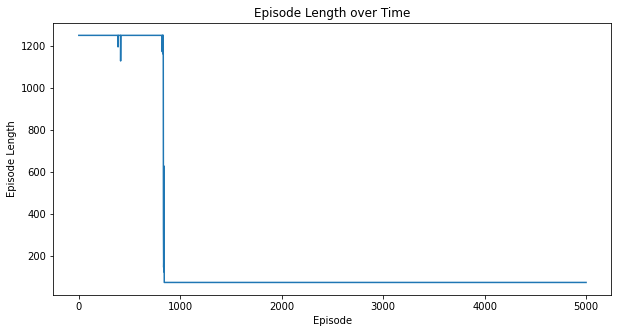

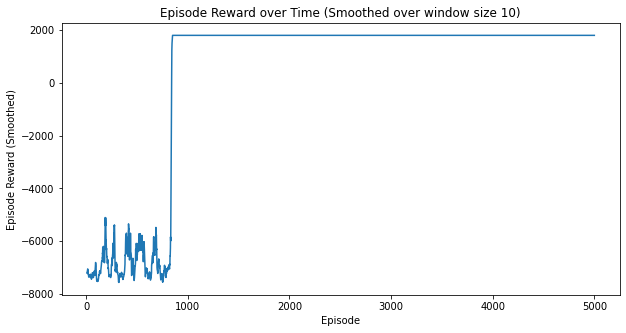

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [ ]:
ql_plotting.plot_episode_stats(stats)

Average reward per hundred episodes 

100 : -7247.825
200 : -6762.4
300 : -6800.475
400 : -7057.725
500 : -6554.98
600 : -6424.175
700 : -6774.0
800 : -7162.325
900 : -1071.725
1000 : 1802.0
1100 : 1802.0
1200 : 1802.0
1300 : 1802.0
1400 : 1802.0
1500 : 1802.0
1600 : 1802.0
1700 : 1802.0
1800 : 1802.0
1900 : 1802.0
2000 : 1802.0
2100 : 1802.0
2200 : 1802.0
2300 : 1802.0
2400 : 1802.0
2500 : 1802.0
2600 : 1802.0
2700 : 1802.0
2800 : 1802.0
2900 : 1802.0
3000 : 1802.0
3100 : 1802.0
3200 : 1802.0
3300 : 1802.0
3400 : 1802.0
3500 : 1802.0
3600 : 1802.0
3700 : 1802.0
3800 : 1802.0
3900 : 1802.0
4000 : 1802.0
4100 : 1802.0
4200 : 1802.0
4300 : 1802.0
4400 : 1802.0
4500 : 1802.0
4600 : 1802.0
4700 : 1802.0
4800 : 1802.0
4900 : 1802.0
5000 : 1802.0


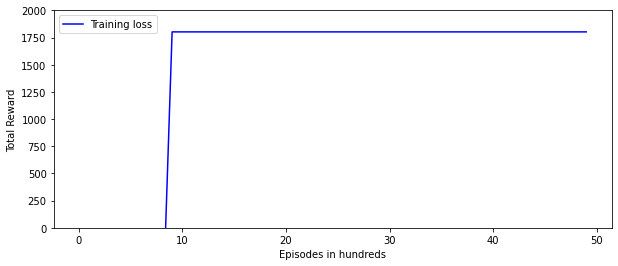

In [ ]:
rewards_per_hundred_episodes = np.split(np.array(episode_rewards),
                               num_episodes/100)

reward_value_list = []

count = 100
print("Average reward per hundred episodes \n")
for i in rewards_per_hundred_episodes:
  print(count, ":", str(sum(i) / 100))
  
  current_reward_value = sum(i) / 100
  reward_value_list.append(current_reward_value)
  count = count + 100
    
    
plt.figure(figsize=(10,4))
plt.ylim(0, 2000)

plt.plot(reward_value_list, 'b', label='Training loss')
plt.xlabel('Episodes in hundreds')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

### 3.1.2. Evaluate Performance after training

In [ ]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100
np.random.seed(4)
action_idx = {0: "north", 1: "south", 2: "west", 3: "east", 4: "pick_up", 5: "drop_off"}
for _ in range(episodes):
    state = uber.reset()
    epochs, reward = 0, 0
    done = False
    
    while not done:
        action = np.argmax(Q_matrix[state, :])
        
        reward, state, done, = uber.step(action_idx[action])

        epochs += 1

    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average reward per episode: {reward}")

Results after 100 episodes:
Average timesteps per episode: 73.0
Average reward per episode: 1802.0


In [ ]:
t_steps, reward = 0, 0
action_idx = {0: "north", 1: "south", 2: "west", 3: "east", 4: "pick_up", 5: "drop_off"}
frames = [] # for animation
done = False
state = uber.reset()
while not done:
    action = np.argmax(Q_matrix[state, :])
    reward, state, done = uber.step(action_idx[action]) 
    
    frames.append({
        'frame': ('\n'.join(" ".join(str(char) for char in row) for row in uber.display())),
        'state': state,
        'action': action_idx[action],
        'reward': reward,
        'done': done
        }
    )

    t_steps += 1   
    
print("Timesteps taken: {}".format(t_steps))
print("Total reward accumulated: {}".format(reward))

Timesteps taken: 73
Total reward accumulated: 1802.0


In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"reward: {frame['reward']}")
        print(f"Done: {frame['done']}")
        sleep(0.1)
        
print_frames(frames)

■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ . ■ ■ . . ■ . ■ ■ . ■ . ■ . ■ . ■ ■ . ■ . C ■
■ . . . ■ ■ . . . . ■ . ■ . . . . . . ■ . . . ■ ■
■ ■ . ■ ■ . . ■ ■ ■ ■ . ■ . ■ ■ ■ ■ ■ ■ . ■ . . ■
■ . . . ■ ■ . . ■ . . . . . . . . . . . . ■ ■ . ■
■ ■ . ■ ■ ■ . ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ . ■
■ ■ . ■ . ■ . ■ . . . . . . . . . . ■ ■ ■ . ■ ■ ■
■ . . . . . . . . ■ ■ . ■ ■ . ■ ■ . . . . . . ■ ■
■ ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ . . ■ ■ ■ . ■ . ■ . . ■
■ . . . . ■ . . . ■ . ■ ■ ■ . . . ■ . ■ . ■ ■ . ■
■ ■ ■ ■ . . . ■ . . . ■ . ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■
■ . . . . ■ ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . . ■ . . . ■
■ ■ ■ ■ . ■ . ■ ■ . ■ ■ . ■ . ■ ■ . ■ ■ ■ . ■ ■ ■
■ . ■ . . . . ■ . . . ■ . ■ . . . . . . . . ■ . ■
■ . ■ ■ . ■ ■ ■ . ■ ■ ■ . ■ . ■ ■ ■ . ■ . ■ ■ . ■
■ . . . . . . . . . ■ . . . . . . ■ ■ ■ ■ ■ . . ■
■ ■ ■ ■ . ■ . ■ ■ . . . ■ ■ ■ . ■ ■ ■ . ■ ■ . ■ ■
■ . . . . ■ . ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . ■ ■ . . ■
■ ■ ■ . ■ ■ ■ ■ . ■ . ■ ■ . ■ ■ . ■ ■ . . ■ . ■ ■
■ . . . . . . . . . . . . . . . . ■ ■ . ■ ■ . . ■


## 3.2. Hyperparameter optimization


### 3.2.1. Custom Grid Search

In [ ]:
%%time

# Run Q-learning algorithm
learning_rates = [0.01, 0.1]
discount_factors = [0.9, 1.0]
epsilons = [1.0, 0.9, 0.8, 0.7]
decays = [0.9, 0.99]


uber = CityGrid(25, 25)
uber.reset()
print("This is the starting space: ", uber.reset())
print("*******BEGIN GRID SEARCH******************")
for alpha in learning_rates:
  for gamma in discount_factors:
    for epsilon in epsilons:
      for decay in decays:
        uber.reset()
        policy_epsilon_greedy = Epsilon_Greedy_Policy(uber) 
        episode_rewards, _, _, _, episode_errors =  policy_epsilon_greedy.Q_learning(num_episodes=2000, alpha=alpha, gamma=gamma, epsilon=epsilon, decay=decay)
        print("LEARNING RATE : {} | DISCOUNT FACTOR : {} | EPSILON: {} | DECAY : {} ".format(alpha, gamma, epsilon, decay))
        print('REWARD: ', max(episode_rewards))
        print('ERROR: ', max(episode_errors))

This is the starting space:  429
*******BEGIN GRID SEARCH******************
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 0.9 | EPSILON: 1.0 | DECAY : 0.9 
REWARD:  -1250.0
ERROR:  46728.96878545067
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 0.9 | EPSILON: 1.0 | DECAY : 0.99 
REWARD:  -1250.0
ERROR:  562927.0952193249
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 0.9 | EPSILON: 0.9 | DECAY : 0.9 
REWARD:  -1250.0
ERROR:  74991.37148243093
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 0.9 | EPSILON: 0.9 | DECAY : 0.99 
REWARD:  -1250.0
ERROR:  563918.7447212576
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 0.9 | EPSILON: 0.8 | DECAY : 0.9 
REWARD:  -1117.5
ERROR:  5366.950560313303
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 0.9 | EPSILON: 0.8 | DECAY : 0.99 
REWARD:  -1250.0
ERROR:  436677.2336064696
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 0.9 | EPSILON: 0.7 | DECAY : 0.9 
REWARD:  -12

In [ ]:
'''
LEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | EPSILON: 1.0 | DECAY : 0.9 
REWARD:  1802.0
ERROR:  77291.90094988933

LEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | EPSILON: 1.0 | DECAY : 0.99 
REWARD:  1802.0
ERROR:  187646.5793481912

LEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | EPSILON: 0.9 | DECAY : 0.9 
REWARD:  1802.0
ERROR:  64701.36146692347

LEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | EPSILON: 0.8 | DECAY : 0.9 
REWARD:  1802.0
ERROR:  74835.6443245278

LEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | EPSILON: 0.8 | DECAY : 0.99 
REWARD:  1802.0
ERROR:  93951.5947042083

'''

'\nLEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | EPSILON: 1.0 | DECAY : 0.9 \nREWARD:  1802.0\nERROR:  77291.90094988933\n\nLEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | EPSILON: 1.0 | DECAY : 0.99 \nREWARD:  1802.0\nERROR:  187646.5793481912\n\nLEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | EPSILON: 0.9 | DECAY : 0.9 \nREWARD:  1802.0\nERROR:  64701.36146692347\n\nLEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | EPSILON: 0.8 | DECAY : 0.9 \nREWARD:  1802.0\nERROR:  74835.6443245278\n\nLEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | EPSILON: 0.8 | DECAY : 0.99 \nREWARD:  1802.0\nERROR:  93951.5947042083\n\n'

### 3.2.2. Hyperparameter tuning

In [ ]:
q_rewards1, q_time1, q_mat1, q_stats1, q_error1 = policy_epsilon_greedy.Q_learning(num_episodes=2000, alpha=0.1, gamma=1, epsilon=1, decay=0.9)
q_rewards2, q_time2, q_mat2, q_stats2, q_error2 = policy_epsilon_greedy.Q_learning(num_episodes=2000, alpha=0.1, gamma=1, epsilon=1, decay=0.99)
q_rewards3, q_time3, q_mat3, q_stats3, q_error3 = policy_epsilon_greedy.Q_learning(num_episodes=2000, alpha=0.1, gamma=1, epsilon=0.9, decay=0.9)
q_rewards4, q_time4, q_mat4, q_stats4, q_error4 = policy_epsilon_greedy.Q_learning(num_episodes=2000, alpha=0.1, gamma=1, epsilon=0.8, decay=0.9)
q_rewards5, q_time5, q_mat5, q_stats5, q_error5 = policy_epsilon_greedy.Q_learning(num_episodes=2000, alpha=0.1, gamma=1, epsilon=0.8, decay=0.99)

Episode 2000/2000.

In [ ]:
error1_smoothed = pd.Series(q_error1).rolling(10, min_periods=10).mean()
error2_smoothed = pd.Series(q_error2).rolling(10, min_periods=10).mean()
error3_smoothed = pd.Series(q_error3).rolling(10, min_periods=10).mean()
error4_smoothed = pd.Series(q_error4).rolling(10, min_periods=10).mean()
error5_smoothed = pd.Series(q_error5).rolling(10, min_periods=10).mean()

df_errors = pd.DataFrame({
  "alpha=0.1, gamma=1, epsilon=1, decay=0.9": error1_smoothed,
  "alpha=0.1, gamma=1, epsilon=1, decay=0.99": error2_smoothed,
  "alpha=0.1, gamma=1, epsilon=0.9, decay=0.9": error3_smoothed,
  "alpha=0.1, gamma=1, epsilon=0.8, decay=0.9": error4_smoothed,
  "alpha=0.1, gamma=1, epsilon=0.8, decay=0.99": error5_smoothed,
})

rewards1_smoothed = pd.Series(q_rewards1).rolling(10, min_periods=10).mean()
rewards2_smoothed = pd.Series(q_rewards2).rolling(10, min_periods=10).mean()
rewards3_smoothed = pd.Series(q_rewards3).rolling(10, min_periods=10).mean()
rewards4_smoothed = pd.Series(q_rewards4).rolling(10, min_periods=10).mean()
rewards5_smoothed = pd.Series(q_rewards5).rolling(10, min_periods=10).mean()

df_rewards = pd.DataFrame({
  "alpha=0.1, gamma=1, epsilon=1, decay=0.9": rewards1_smoothed,
  "alpha=0.1, gamma=1, epsilon=1, decay=0.99": rewards2_smoothed,
  "alpha=0.1, gamma=1, epsilon=0.9, decay=0.9": rewards3_smoothed,
  "alpha=0.1, gamma=1, epsilon=0.8, decay=0.9": rewards4_smoothed,
  "alpha=0.1, gamma=1, epsilon=0.8, decay=0.99": rewards5_smoothed,
})

Text(0.5, 1.0, 'Total Rewards vs Episodes')

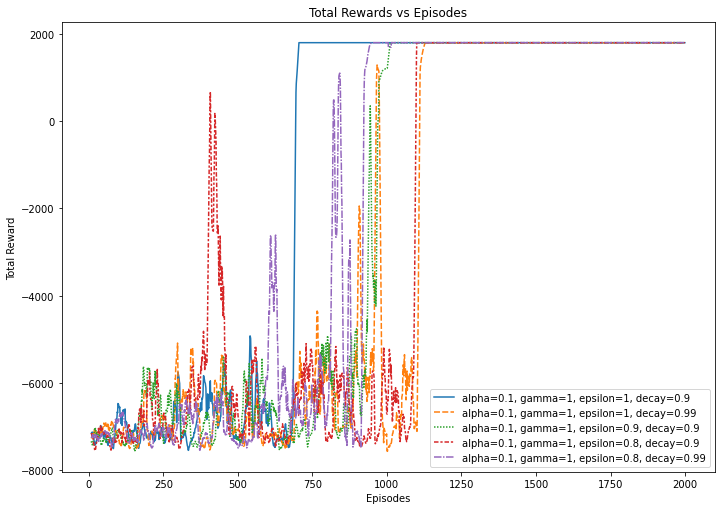

In [ ]:
sns.lineplot(data=df_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title("Total Rewards vs Episodes")

Text(0.5, 1.0, 'Total Errors vs Episodes')

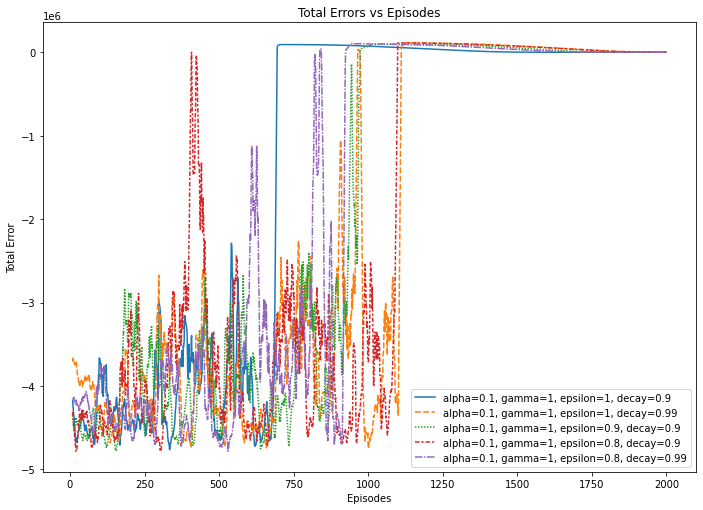

In [ ]:
sns.lineplot(data=df_errors)
plt.xlabel('Episodes')
plt.ylabel('Total Error')
plt.title("Total Errors vs Episodes")

## 3.3. Final Model

In [ ]:
%%time
episode_rewards, num_episodes, Q_matrix, stats, episode_error = policy_epsilon_greedy.Q_learning(num_episodes=5000, alpha=0.1, gamma=1, epsilon=1, decay=0.9)

Episode 5000/5000.CPU times: user 24.7 s, sys: 2.59 s, total: 27.3 s
Wall time: 24.6 s


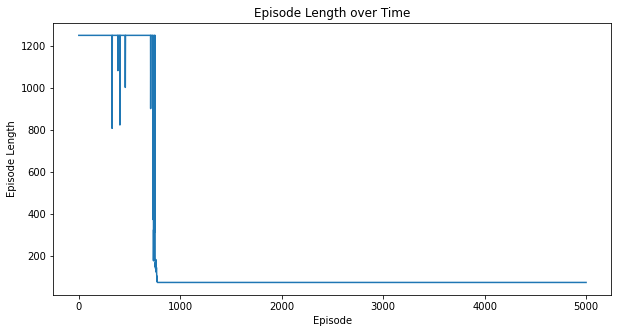

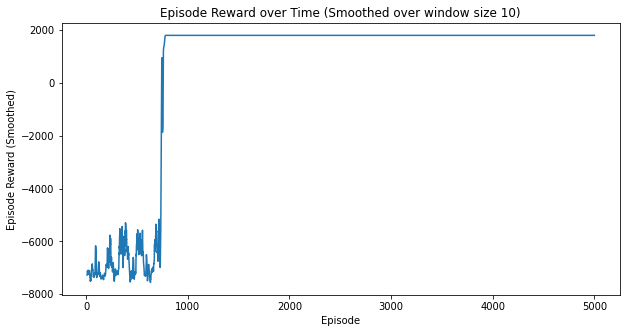

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [ ]:
ql_plotting.plot_episode_stats(stats)

Average reward per hundred episodes 

100 : -7120.475
200 : -7214.0
300 : -6840.85
400 : -6228.615
500 : -6920.225
600 : -6515.15
700 : -6790.55
800 : -1413.74
900 : 1802.0
1000 : 1802.0
1100 : 1802.0
1200 : 1802.0
1300 : 1802.0
1400 : 1802.0
1500 : 1802.0
1600 : 1802.0
1700 : 1802.0
1800 : 1802.0
1900 : 1802.0
2000 : 1802.0
2100 : 1802.0
2200 : 1802.0
2300 : 1802.0
2400 : 1802.0
2500 : 1802.0
2600 : 1802.0
2700 : 1802.0
2800 : 1802.0
2900 : 1802.0
3000 : 1802.0
3100 : 1802.0
3200 : 1802.0
3300 : 1802.0
3400 : 1802.0
3500 : 1802.0
3600 : 1802.0
3700 : 1802.0
3800 : 1802.0
3900 : 1802.0
4000 : 1802.0
4100 : 1802.0
4200 : 1802.0
4300 : 1802.0
4400 : 1802.0
4500 : 1802.0
4600 : 1802.0
4700 : 1802.0
4800 : 1802.0
4900 : 1802.0
5000 : 1802.0


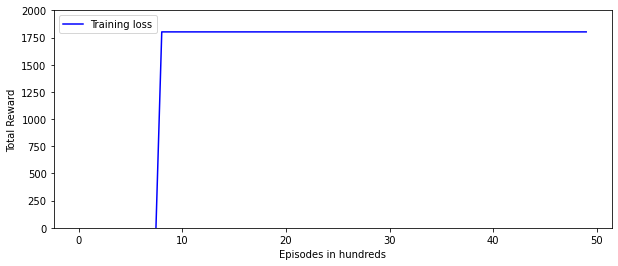

In [ ]:
rewards_per_hundred_episodes = np.split(np.array(episode_rewards),
                               num_episodes/100)

reward_value_list = []

count = 100
print("Average reward per hundred episodes \n")
for i in rewards_per_hundred_episodes:
  print(count, ":", str(sum(i) / 100))
  
  current_reward_value = sum(i) / 100
  reward_value_list.append(current_reward_value)
  count = count + 100
    
    
plt.figure(figsize=(10,4))
plt.ylim(0, 2000)

plt.plot(reward_value_list, 'b', label='Training loss')
plt.xlabel('Episodes in hundreds')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

In [ ]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100
np.random.seed(4)
action_idx = {0: "north", 1: "south", 2: "west", 3: "east", 4: "pick_up", 5: "drop_off"}
for _ in range(episodes):
  state = uber.reset()
  epochs, reward = 0, 0
  done = False
  
  while not done:
      action = np.argmax(Q_matrix[state, :])
      
      reward, state, done, = uber.step(action_idx[action])

      epochs += 1

  total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average reward per episode: {reward}")

Results after 100 episodes:
Average timesteps per episode: 73.0
Average reward per episode: 1802.0


In [ ]:
t_steps, reward = 0, 0
action_idx = {0: "north", 1: "south", 2: "west", 3: "east", 4: "pick_up", 5: "drop_off"}
frames = [] # for animation
done = False
state = uber.reset()
while not done:
  action = np.argmax(Q_matrix[state, :])
  reward, state, done = uber.step(action_idx[action]) 
  
  frames.append({
      'frame': ('\n'.join(" ".join(str(char) for char in row) for row in uber.display())),
      'state': state,
      'action': action_idx[action],
      'reward': reward,
      'done': done
      }
  )

  t_steps += 1   
  
print("Timesteps taken: {}".format(t_steps))
print("Total reward accumulated: {}".format(reward))

Timesteps taken: 73
Total reward accumulated: 1802.0


In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
  for i, frame in enumerate(frames):
    clear_output(wait=True)
    print(frame['frame'])
    print(f"Timestep: {i + 1}")
    print(f"State: {frame['state']}")
    print(f"Action: {frame['action']}")
    print(f"reward: {frame['reward']}")
    print(f"Done: {frame['done']}")
    sleep(0.1)
      
print_frames(frames)

■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ . ■ ■ . . ■ . ■ ■ . ■ . ■ . ■ . ■ ■ . ■ . C ■
■ . . . ■ ■ . . . . ■ . ■ . . . . . . ■ . . . ■ ■
■ ■ . ■ ■ . . ■ ■ ■ ■ . ■ . ■ ■ ■ ■ ■ ■ . ■ . . ■
■ . . . ■ ■ . . ■ . . . . . . . . . . . . ■ ■ . ■
■ ■ . ■ ■ ■ . ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ . ■
■ ■ . ■ . ■ . ■ . . . . . . . . . . ■ ■ ■ . ■ ■ ■
■ . . . . . . . . ■ ■ . ■ ■ . ■ ■ . . . . . . ■ ■
■ ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ . . ■ ■ ■ . ■ . ■ . . ■
■ . . . . ■ . . . ■ . ■ ■ ■ . . . ■ . ■ . ■ ■ . ■
■ ■ ■ ■ . . . ■ . . . ■ . ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■
■ . . . . ■ ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . . ■ . . . ■
■ ■ ■ ■ . ■ . ■ ■ . ■ ■ . ■ . ■ ■ . ■ ■ ■ . ■ ■ ■
■ . ■ . . . . ■ . . . ■ . ■ . . . . . . . . ■ . ■
■ . ■ ■ . ■ ■ ■ . ■ ■ ■ . ■ . ■ ■ ■ . ■ . ■ ■ . ■
■ . . . . . . . . . ■ . . . . . . ■ ■ ■ ■ ■ . . ■
■ ■ ■ ■ . ■ . ■ ■ . . . ■ ■ ■ . ■ ■ ■ . ■ ■ . ■ ■
■ . . . . ■ . ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . ■ ■ . . ■
■ ■ ■ . ■ ■ ■ ■ . ■ . ■ ■ . ■ ■ . ■ ■ . . ■ . ■ ■
■ . . . . . . . . . . . . . . . . ■ ■ . ■ ■ . . ■


## 4. Upper Confidence Bound (UCB) Policy

In [ ]:
class UCB_Policy():
    
  def __init__(self, environment):
    self.env = environment
    self.action_space = self.env.action_space
    self.state_space = self.env.state_space 
    self.action_idx = {0: "north", 1: "south", 2: "west", 3: "east", 4: "pick_up", 5: "drop_off"}
  
  def Q_learning(self, num_episodes, alpha, gamma, c):
    Q_matrix = np.zeros((self.state_space, self.action_space))
    episode_rewards = np.zeros(num_episodes)
    episode_error = np.zeros(num_episodes)
    Nt_a = np.ones((self.state_space, self.action_space)) # to avoid dividing by zero
    
    # using a modified version of plotting.py from rllib library
    stats = ql_plotting.EpisodeStats(
      episode_lengths=np.zeros(num_episodes),
      episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
      # Print out which episode we're on for debugging
      if (i_episode + 1) % 100 == 0:
          print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
          sys.stdout.flush()
        
      # Reset the environment
      current_state = self.env.reset()
      
      for t in itertools.count(start=1):
            
        current_action = np.argmax(Q_matrix[current_state] + c * np.sqrt(np.log(t)/Nt_a[current_state]))
        
        # Take_action
        reward, next_state, done = self.env.step(self.action_idx[current_action])
        
        episode_rewards[i_episode] = reward
        Nt_a[current_state, current_action] += 1
        
        
        # Update statistics
        stats.episode_rewards[i_episode] = reward
        stats.episode_lengths[i_episode] = t
        
        # TD Update rule
        td_target = reward + gamma * np.max(Q_matrix[next_state, :])
        td_error = td_target - Q_matrix[current_state, current_action]

        Q_matrix[current_state, current_action] += alpha * td_error
        
        episode_error[i_episode] += td_error
        if done:
            break
        
        current_state = next_state
        
    return episode_rewards, num_episodes, Q_matrix, stats, episode_error

In [ ]:
uber = CityGrid(25, 25)
uber.reset()
policy_ucb = UCB_Policy(uber)

## 4.1. Training with UCB Policy

In [ ]:
%%time
episode_rewards, num_episodes, Q_matrix, stats, episode_error = policy_ucb.Q_learning(num_episodes=5000, alpha=0.1, gamma=1, c=1)

Episode 5000/5000.CPU times: user 34.6 s, sys: 3.66 s, total: 38.3 s
Wall time: 34.4 s


### 4.1.1. Training performance

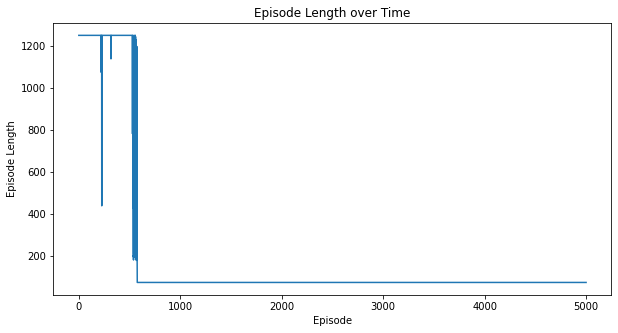

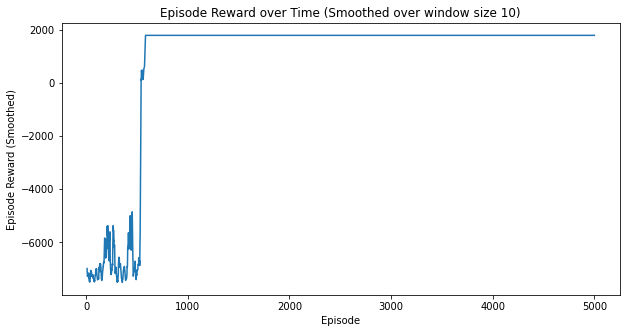

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [ ]:
ql_plotting.plot_episode_stats(stats)

Average reward per hundred episodes 

100 : -7232.1
200 : -6855.275
300 : -6478.905
400 : -7155.755
500 : -6378.975
600 : -1487.13
700 : 1802.0
800 : 1802.0
900 : 1802.0
1000 : 1802.0
1100 : 1802.0
1200 : 1802.0
1300 : 1802.0
1400 : 1802.0
1500 : 1802.0
1600 : 1802.0
1700 : 1802.0
1800 : 1802.0
1900 : 1802.0
2000 : 1802.0
2100 : 1802.0
2200 : 1802.0
2300 : 1802.0
2400 : 1802.0
2500 : 1802.0
2600 : 1802.0
2700 : 1802.0
2800 : 1802.0
2900 : 1802.0
3000 : 1802.0
3100 : 1802.0
3200 : 1802.0
3300 : 1802.0
3400 : 1802.0
3500 : 1802.0
3600 : 1802.0
3700 : 1802.0
3800 : 1802.0
3900 : 1802.0
4000 : 1802.0
4100 : 1802.0
4200 : 1802.0
4300 : 1802.0
4400 : 1802.0
4500 : 1802.0
4600 : 1802.0
4700 : 1802.0
4800 : 1802.0
4900 : 1802.0
5000 : 1802.0


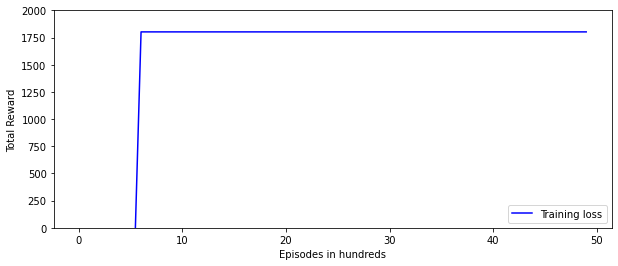

In [ ]:
rewards_per_hundred_episodes = np.split(np.array(episode_rewards),
                               num_episodes/100)

reward_value_list = []

count = 100
print("Average reward per hundred episodes \n")
for i in rewards_per_hundred_episodes:
  print(count, ":", str(sum(i) / 100))
  
  current_reward_value = sum(i) / 100
  reward_value_list.append(current_reward_value)
  count = count + 100
    
    
plt.figure(figsize=(10,4))
plt.ylim(0, 2000)

plt.plot(reward_value_list, 'b', label='Training loss')
plt.xlabel('Episodes in hundreds')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

### 4.1.2. Evaluate Performance after training

In [ ]:
"""Evaluate agent's performance after Q-learning"""

total_epochs = 0
episodes = 100
np.random.seed(4)
action_idx = {0: "north", 1: "south", 2: "west", 3: "east", 4: "pick_up", 5: "drop_off"}
for _ in range(episodes):
  state = uber.reset()
  epochs, reward = 0, 0
  done = False
  
  while not done:
      action = np.argmax(Q_matrix[state, :])
      
      reward, state, done, = uber.step(action_idx[action])

      epochs += 1

  total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average reward per episode: {reward}")

Results after 100 episodes:
Average timesteps per episode: 73.0
Average reward per episode: 1802.0


In [ ]:
t_steps, reward = 0, 0
action_idx = {0: "north", 1: "south", 2: "west", 3: "east", 4: "pick_up", 5: "drop_off"}
frames = [] # for animation
done = False
state = uber.reset()
total_rewards = 0
while not done:
  action = np.argmax(Q_matrix[state, :])
  reward, state, done = uber.step(action_idx[action]) 
  
  frames.append({
    'frame': ('\n'.join(" ".join(str(char) for char in row) for row in uber.display())),
    'state': state,
    'action': action_idx[action],
    'reward': reward,
    'done': done
    }
  )
  t_steps += 1   
     
print("Timesteps taken: {}".format(epochs))
print("Total reward accumulated: {}".format(reward))

Timesteps taken: 73
Total reward accumulated: 1802.0


In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
  for i, frame in enumerate(frames):
    clear_output(wait=True)
    print(frame['frame'])
    print(f"Timestep: {i + 1}")
    print(f"State: {frame['state']}")
    print(f"Action: {frame['action']}")
    print(f"reward: {frame['reward']}")
    print(f"Done: {frame['done']}")
    sleep(0.1)
        
print_frames(frames)

■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ . ■ ■ . . ■ . ■ ■ . ■ . ■ . ■ . ■ ■ . ■ . C ■
■ . . . ■ ■ . . . . ■ . ■ . . . . . . ■ . . . ■ ■
■ ■ . ■ ■ . . ■ ■ ■ ■ . ■ . ■ ■ ■ ■ ■ ■ . ■ . . ■
■ . . . ■ ■ . . ■ . . . . . . . . . . . . ■ ■ . ■
■ ■ . ■ ■ ■ . ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ . ■
■ ■ . ■ . ■ . ■ . . . . . . . . . . ■ ■ ■ . ■ ■ ■
■ . . . . . . . . ■ ■ . ■ ■ . ■ ■ . . . . . . ■ ■
■ ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ . . ■ ■ ■ . ■ . ■ . . ■
■ . . . . ■ . . . ■ . ■ ■ ■ . . . ■ . ■ . ■ ■ . ■
■ ■ ■ ■ . . . ■ . . . ■ . ■ ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■
■ . . . . ■ ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . . ■ . . . ■
■ ■ ■ ■ . ■ . ■ ■ . ■ ■ . ■ . ■ ■ . ■ ■ ■ . ■ ■ ■
■ . ■ . . . . ■ . . . ■ . ■ . . . . . . . . ■ . ■
■ . ■ ■ . ■ ■ ■ . ■ ■ ■ . ■ . ■ ■ ■ . ■ . ■ ■ . ■
■ . . . . . . . . . ■ . . . . . . ■ ■ ■ ■ ■ . . ■
■ ■ ■ ■ . ■ . ■ ■ . . . ■ ■ ■ . ■ ■ ■ . ■ ■ . ■ ■
■ . . . . ■ . ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . ■ ■ . . ■
■ ■ ■ . ■ ■ ■ ■ . ■ . ■ ■ . ■ ■ . ■ ■ . . ■ . ■ ■
■ . . . . . . . . . . . . . . . . ■ ■ . ■ ■ . . ■


## 4.2. Hyperparameter optimization

### 4.2.1. Custom Grid Search

In [ ]:
%%time

# Run Q-learning algorithm
learning_rates = [0.01, 0.1]
discount_factors = [0.9, 1.0]
conf = [0.5, 1.0, 1.5, 2.0]

uber = CityGrid(25, 25)
uber.reset()
print("*******BEGIN GRID SEARCH******************")
for alpha in learning_rates:
  for gamma in discount_factors:
    for c in conf:
      uber.reset()
      policy_ucb = UCB_Policy(uber) 
      episode_rewards, _, _, _, episode_errors =  policy_ucb.Q_learning(num_episodes=2000, alpha=alpha, gamma=gamma, c=c)
      print("LEARNING RATE : {} | DISCOUNT FACTOR : {} | C: {} ".format(alpha, gamma, c))
      print('REWARD: ', max(episode_rewards))
      print('ERROR: ', max(episode_errors))

*******BEGIN GRID SEARCH******************
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 0.9 | C: 0.5 
REWARD:  -1250.0
ERROR:  -1.356056600343436e-09
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 0.9 | C: 1.0 
REWARD:  -1250.0
ERROR:  65347.11364972649
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 0.9 | C: 1.5 
REWARD:  -1250.0
ERROR:  38347.91874706782
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 0.9 | C: 2.0 
REWARD:  -1250.0
ERROR:  97348.95345452194
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 1.0 | C: 0.5 
REWARD:  -1968.0
ERROR:  -601594.178804787
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 1.0 | C: 1.0 
REWARD:  -510.0
ERROR:  -279894.66074532503
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 1.0 | C: 1.5 
REWARD:  -2048.0
ERROR:  -630205.4820989883
Episode 2000/2000.LEARNING RATE : 0.01 | DISCOUNT FACTOR : 1.0 | C: 2.0 
REWARD:  -1767.5
ERROR:  -457089.19605777785
Episode 2000/2000.LE

In [ ]:
'''
LEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | C: 1.0 
REWARD:  1802.0
ERROR:  72404.40355769036
LEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | C: 1.5 
REWARD:  1802.0
ERROR:  81961.78810306906
LEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | C: 2.0 
REWARD:  1802.0
ERROR:  92375.04983598508
'''

'\nLEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | C: 1.0 \nREWARD:  1802.0\nERROR:  72404.40355769036\nLEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | C: 1.5 \nREWARD:  1802.0\nERROR:  81961.78810306906\nLEARNING RATE : 0.1 | DISCOUNT FACTOR : 1.0 | C: 2.0 \nREWARD:  1802.0\nERROR:  92375.04983598508\n'

In [ ]:
q_rewards1, q_time1, q_mat1, q_stats1, q_error1 = policy_ucb.Q_learning(num_episodes=2000, alpha=0.1, gamma=1.0, c=1)
q_rewards2, q_time2, q_mat2, q_stats2, q_error2 = policy_ucb.Q_learning(num_episodes=2000, alpha=0.1, gamma=1.0, c=1.5)
q_rewards3, q_time3, q_mat3, q_stats3, q_error3 = policy_ucb.Q_learning(num_episodes=2000, alpha=0.1, gamma=1.0, c=2)

Episode 2000/2000.

### 4.2.2. Hyperparameter tuning

In [ ]:
import pandas as pd
error1_smoothed = pd.Series(q_error1).rolling(10, min_periods=10).mean()
error2_smoothed = pd.Series(q_error2).rolling(10, min_periods=10).mean()
error3_smoothed = pd.Series(q_error3).rolling(10, min_periods=10).mean()

df_errors = pd.DataFrame({
  "alpha=0.1, gamma=1, c=1": error1_smoothed,
  "alpha=0.1, gamma=1, c=1.5": error2_smoothed,
  "alpha=0.1, gamma=1, c=2": error3_smoothed,
})

rewards1_smoothed = pd.Series(q_rewards1).rolling(10, min_periods=10).mean()
rewards2_smoothed = pd.Series(q_rewards2).rolling(10, min_periods=10).mean()
rewards3_smoothed = pd.Series(q_rewards3).rolling(10, min_periods=10).mean()

df_rewards = pd.DataFrame({
  "alpha=0.1, gamma=1, c=1": rewards1_smoothed,
  "alpha=0.1, gamma=1, c=1.5": rewards2_smoothed,
  "alpha=0.1, gamma=1, c=2": rewards3_smoothed,
})

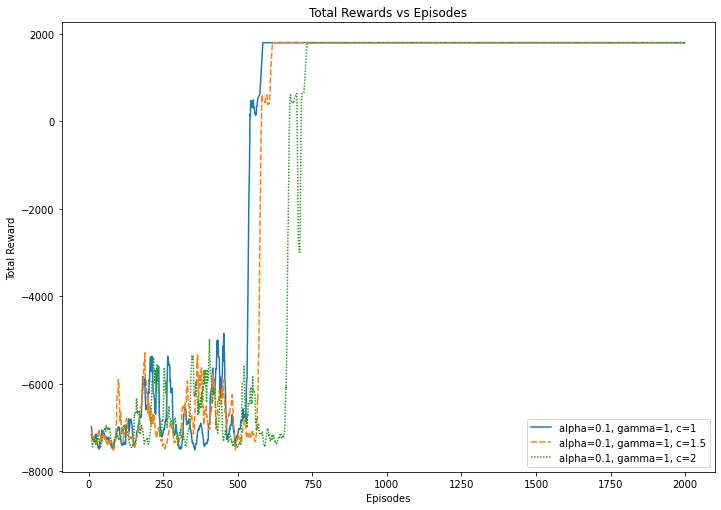

In [ ]:
sns.lineplot(data=df_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title("Total Rewards vs Episodes")
plt.legend(loc='lower right')

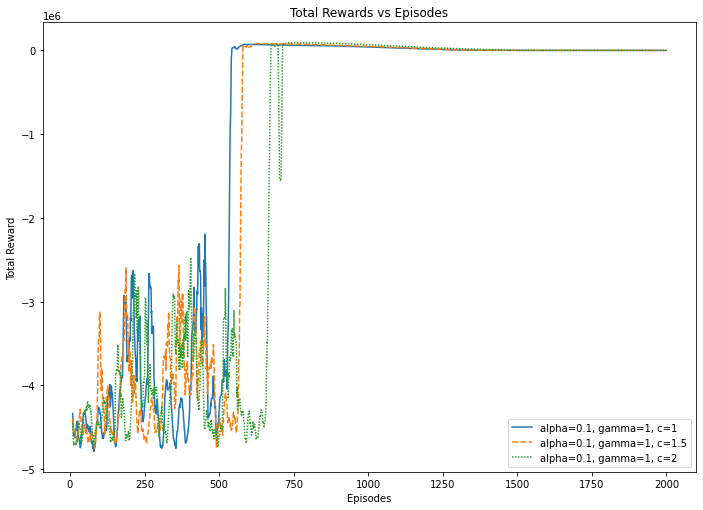

In [ ]:
sns.lineplot(data=df_errors)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title("Total Rewards vs Episodes")
plt.legend(loc='lower right')

## 4.3. Final Model

Final Model is uses the same parameters in section 4.1. Please refer to the initial training models above

# 4. Reinforcement on Bigger Environment

In [ ]:
uber_lrg = CityGrid(40, 40)
uber_lrg.reset()
uber_lrg.render()

■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ . ■ . ■ . . . ■ ■ . . ■ . ■ . ■ . ■ ■ . . ■ ■ . . ■ ■ . ■ ■ . ■ . ■ ■ . . ■
■ . . . . . . ■ ■ ■ ■ . ■ ■ . . . ■ . . ■ ■ . . ■ . ■ ■ . . ■ ■ . ■ . . . . ■ ■
■ . ■ ■ . ■ . . ■ . ■ . ■ ■ . ■ . ■ . ■ ■ . . ■ ■ . ■ ■ . ■ ■ ■ . ■ . ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ . . . . . . ■ ■ ■ . ■ . . ■ ■ . ■ ■ . . . . . . . . . . ■ . ■ . ■
■ . . ■ ■ . ■ ■ ■ . ■ ■ ■ ■ . . . ■ ■ . ■ . . . . . ■ ■ . ■ ■ . ■ ■ . ■ . ■ . ■
■ ■ . ■ . . ■ ■ . . ■ . . ■ ■ ■ . ■ ■ . ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ . ■ ■ . . . . . ■
■ . . . . ■ ■ ■ ■ . ■ . ■ ■ . . . ■ . . . . . . . . . . ■ . ■ . . ■ ■ . ■ ■ ■ ■
■ ■ ■ ■ . ■ ■ . . . . . . ■ ■ ■ . . . ■ . ■ ■ ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . . . ■ ■
■ . ■ ■ . ■ ■ . ■ ■ ■ . ■ ■ . . . ■ ■ ■ ■ ■ ■ . ■ ■ . . . . . . . ■ ■ . ■ . . ■
■ . . ■ . ■ ■ ■ ■ ■ . . . ■ ■ ■ . ■ ■ . ■ . ■ . . ■ . ■ ■ ■ ■ . ■ ■ . . ■ . ■ ■
■ . ■ ■ . D ■ ■ . ■ ■ ■ . ■ . ■ . ■ ■ . ■ . . . ■ ■ . . . . ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ . . ■ ■ . . ■ . . ■ ■ . ■ . ■ . ■ . . 

In [ ]:
policy_ucb_lrg = UCB_Policy(uber_lrg)

In [ ]:
%%time
episode_rewards, num_episodes, Q_matrix, stats, episode_error = policy_ucb_lrg.Q_learning(num_episodes=5000, alpha=0.1, gamma=1, c=1)

Episode 5000/5000.CPU times: user 2min 4s, sys: 12.7 s, total: 2min 17s
Wall time: 2min 3s


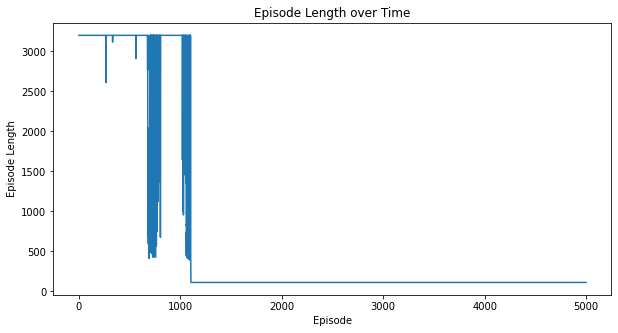

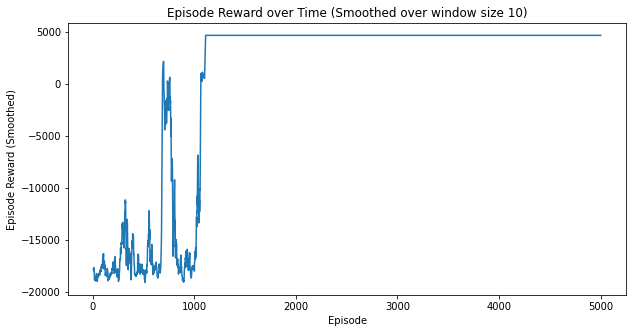

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [ ]:
ql_plotting.plot_episode_stats(stats)

Average reward per hundred episodes 

100 : -18143.1
200 : -18075.1
300 : -16892.41
400 : -15323.81
500 : -17793.7
600 : -16869.26
700 : -13591.83
800 : -4879.91
900 : -16985.09
1000 : -17391.0
1100 : -6890.6
1200 : 4527.7
1300 : 4687.0
1400 : 4687.0
1500 : 4687.0
1600 : 4687.0
1700 : 4687.0
1800 : 4687.0
1900 : 4687.0
2000 : 4687.0
2100 : 4687.0
2200 : 4687.0
2300 : 4687.0
2400 : 4687.0
2500 : 4687.0
2600 : 4687.0
2700 : 4687.0
2800 : 4687.0
2900 : 4687.0
3000 : 4687.0
3100 : 4687.0
3200 : 4687.0
3300 : 4687.0
3400 : 4687.0
3500 : 4687.0
3600 : 4687.0
3700 : 4687.0
3800 : 4687.0
3900 : 4687.0
4000 : 4687.0
4100 : 4687.0
4200 : 4687.0
4300 : 4687.0
4400 : 4687.0
4500 : 4687.0
4600 : 4687.0
4700 : 4687.0
4800 : 4687.0
4900 : 4687.0
5000 : 4687.0


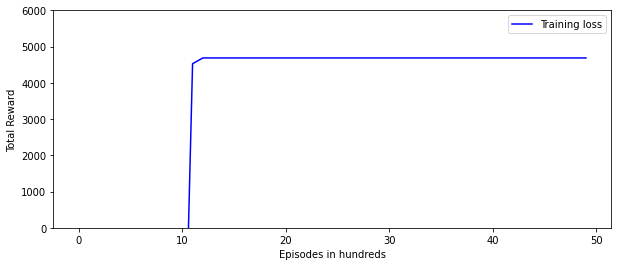

In [ ]:
rewards_per_hundred_episodes = np.split(np.array(episode_rewards),
                               num_episodes/100)

reward_value_list = []

count = 100
print("Average reward per hundred episodes \n")
for i in rewards_per_hundred_episodes:
  print(count, ":", str(sum(i) / 100))
  
  current_reward_value = sum(i) / 100
  reward_value_list.append(current_reward_value)
  count = count + 100
    
    
plt.figure(figsize=(10,4))
plt.ylim(0, 6000)

plt.plot(reward_value_list, 'b', label='Training loss')
plt.xlabel('Episodes in hundreds')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

In [ ]:
"""Evaluate agent's performance after Q-learning"""

total_epochs = 0
episodes = 100
np.random.seed(4)
action_idx = {0: "north", 1: "south", 2: "west", 3: "east", 4: "pick_up", 5: "drop_off"}
for _ in range(episodes):
  state = uber_lrg.reset()
  epochs, reward = 0, 0
  done = False
  
  while not done:
      action = np.argmax(Q_matrix[state, :])
      
      reward, state, done, = uber_lrg.step(action_idx[action])

      epochs += 1

  total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average reward per episode: {reward}")

Results after 100 episodes:
Average timesteps per episode: 113.0
Average reward per episode: 4687.0


In [ ]:
t_steps, reward = 0, 0
action_idx = {0: "north", 1: "south", 2: "west", 3: "east", 4: "pick_up", 5: "drop_off"}
frames = [] # for animation
done = False
state = uber_lrg.reset()
total_rewards = 0
while not done:
  action = np.argmax(Q_matrix[state, :])
  reward, state, done = uber_lrg.step(action_idx[action]) 
  
  frames.append({
    'frame': ('\n'.join(" ".join(str(char) for char in row) for row in uber_lrg.display())),
    'state': state,
    'action': action_idx[action],
    'reward': reward,
    'done': done
    }
  )
  t_steps += 1   
     
print("Timesteps taken: {}".format(epochs))
print("Total reward accumulated: {}".format(reward))

Timesteps taken: 113
Total reward accumulated: 4687.0


In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
  for i, frame in enumerate(frames):
    clear_output(wait=True)
    print(frame['frame'])
    print(f"Timestep: {i + 1}")
    print(f"State: {frame['state']}")
    print(f"Action: {frame['action']}")
    print(f"reward: {frame['reward']}")
    print(f"Done: {frame['done']}")
    sleep(0.1)
        
print_frames(frames)

■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ . ■ . ■ . . . ■ ■ . . ■ . ■ . ■ . ■ ■ . . ■ ■ . . ■ ■ . ■ ■ . ■ . ■ ■ . . ■
■ . . . . . . ■ ■ ■ ■ . ■ ■ . . . ■ . . ■ ■ . . ■ . ■ ■ . . ■ ■ . ■ . . . . ■ ■
■ . ■ ■ . ■ . . ■ . ■ . ■ ■ . ■ . ■ . ■ ■ . . ■ ■ . ■ ■ . ■ ■ ■ . ■ . ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ . . . . . . ■ ■ ■ . ■ . . ■ ■ . ■ ■ . . . . . . . . . . ■ . ■ . ■
■ . . ■ ■ . ■ ■ ■ . ■ ■ ■ ■ . . . ■ ■ . ■ . . . . . ■ ■ . ■ ■ . ■ ■ . ■ . ■ . ■
■ ■ . ■ . . ■ ■ . . ■ . . ■ ■ ■ . ■ ■ . ■ . ■ ■ ■ ■ ■ ■ ■ ■ ■ . ■ ■ . . . . . ■
■ . . . . ■ ■ ■ ■ . ■ . ■ ■ . . . ■ . . . . . . . . . . ■ . ■ . . ■ ■ . ■ ■ ■ ■
■ ■ ■ ■ . ■ ■ . . . . . . ■ ■ ■ . . . ■ . ■ ■ ■ ■ ■ ■ ■ ■ . ■ ■ ■ ■ . . . . ■ ■
■ . ■ ■ . ■ ■ . ■ ■ ■ . ■ ■ . . . ■ ■ ■ ■ ■ ■ . ■ ■ . . . . . . . ■ ■ . ■ . . ■
■ . . ■ . ■ ■ ■ ■ ■ . . . ■ ■ ■ . ■ ■ . ■ . ■ . . ■ . ■ ■ ■ ■ . ■ ■ . . ■ . ■ ■
■ . ■ ■ . C ■ ■ . ■ ■ ■ . ■ . ■ . ■ ■ . ■ . . . ■ ■ . . . . ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ . . ■ ■ . . ■ . . ■ ■ . ■ . ■ . ■ . . 